# Yes Bank Stock Price Analysis & Prediction

This document covers the complete end-to-end workflow for the Yes Bank stock price project:

Exploratory Data Analysis (EDA)

Data Cleaning

Feature Engineering

Visualization

Modeling & Forecasting

Evaluation & Insights

 Models Used:
 1. ARIMA
 2. Prophet
 3. Linear Regression
 4. LSTM (Deep Learning)

 Includes:
 - Model evaluation
 - Trend comparison charts
 - Hyperparameter tuning

## 1. Import Required Libraries

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression


from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## 2. Load Dataset

In [309]:

df = pd.read_csv(r"C:\Users\mayank.puri\Downloads\data_YesBank_StockPrices.csv")
df.head()


,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


## 3. Exploratory Data Analysis (EDA)

Initial inspection


In [310]:
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [311]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


In [312]:

df.describe()


,Open,High,Low,Close
count,185.000000,185.000000,185.000000,185.000000
mean,105.541405,116.104324,94.947838,105.204703
std,98.879850,106.333497,91.219415,98.583153
min,10.000000,11.240000,5.550000,9.980000
25%,33.800000,36.140000,28.510000,33.450000
50%,62.980000,72.550000,58.000000,62.540000
75%,153.000000,169.190000,138.350000,153.300000
max,369.950000,404.000000,345.500000,367.900000


Observations:

Date column needs datetime conversion

Prices are numerical

Dataset is time-series in nature

In [313]:

# Ensure Date is string
df['Date'] = df['Date'].astype(str)

# Extract year number (5,6,7 → 2005,2006,2007)
df['Year'] = df['Date'].str.extract(r'(\d+)').astype(int) + 2000

# Extract month name (Jul, Aug, Jan, etc.)
df['Month'] = df['Date'].str.extract(r'([A-Za-z]{3})')

# Create proper datetime (1st day of month)
df['Date'] = pd.to_datetime(
    df['Year'].astype(str) + '-' + df['Month'] + '-01',
    format='%Y-%b-%d'
)

# Cleanup
df.drop(columns=['Year', 'Month'], inplace=True)
df = df.sort_values('Date').reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close
0,2005-07-01,13.00,14.00,11.25,12.46
1,2005-08-01,12.58,14.88,12.55,13.42
2,2005-09-01,13.48,14.87,12.27,13.30
3,2005-10-01,13.20,14.47,12.40,12.99
4,2005-11-01,13.35,13.88,12.88,13.41


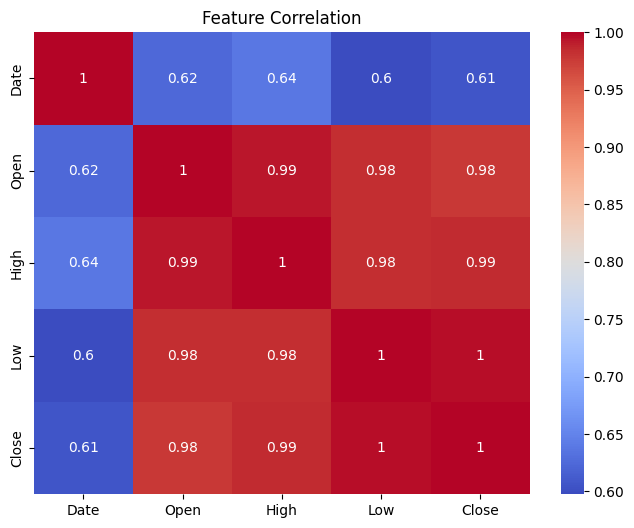

In [314]:

# Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()


## 4. Data Cleaning

4.2 Missing Values

In [315]:

# Missing values
df.isnull().sum()
df.fillna(method='ffill', inplace=True)


C:\Users\mayank.puri\AppData\Local\Temp\ipykernel_6664\226877026.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


4.3 Outlier Check (IQR)

In [316]:
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1
print(f'IQR: {IQR}')

IQR: 119.85000000000001


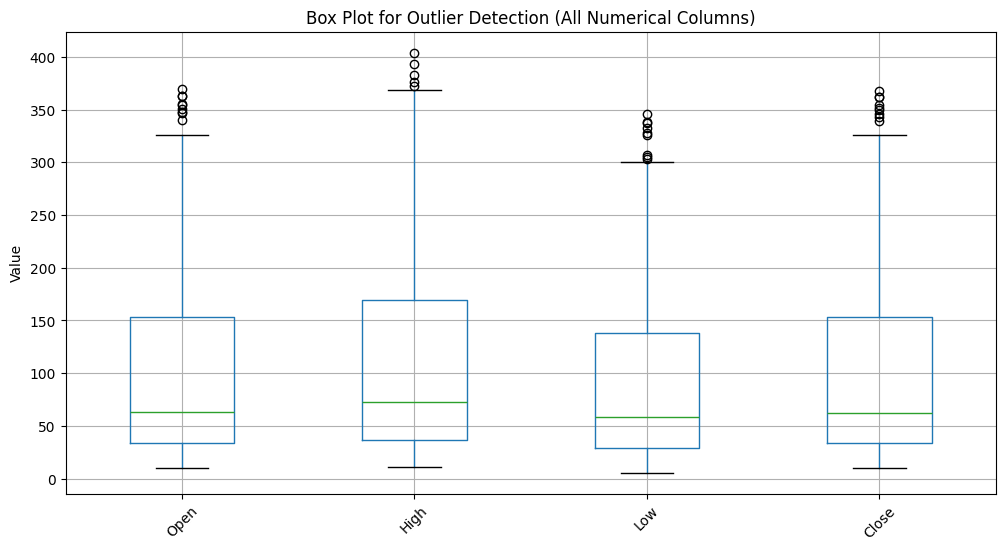

In [317]:
numerical_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12,6))
df[numerical_cols].boxplot(rot=45)
plt.title('Box Plot for Outlier Detection (All Numerical Columns)')
plt.ylabel('Value')
plt.show()

(Extreme values retained since they reflect real market events.)

5. Exploratory Data Analysis (EDA)

5.1 Closing Price Trend

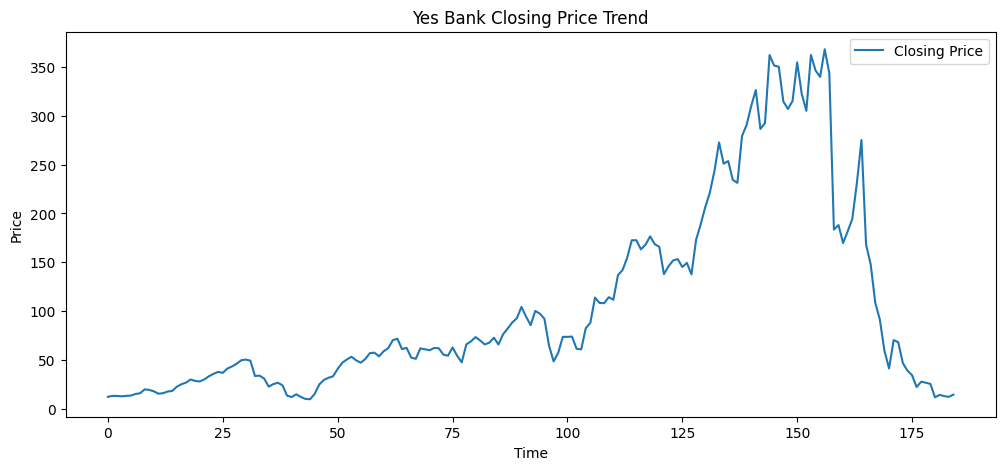

In [318]:

plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Closing Price')
plt.title('Yes Bank Closing Price Trend')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


5.2 Moving Averages

In [319]:
df['MA20'] = df['Close'].rolling(20).mean()
# df['MA50'] = df['Close'].rolling(50).mean()

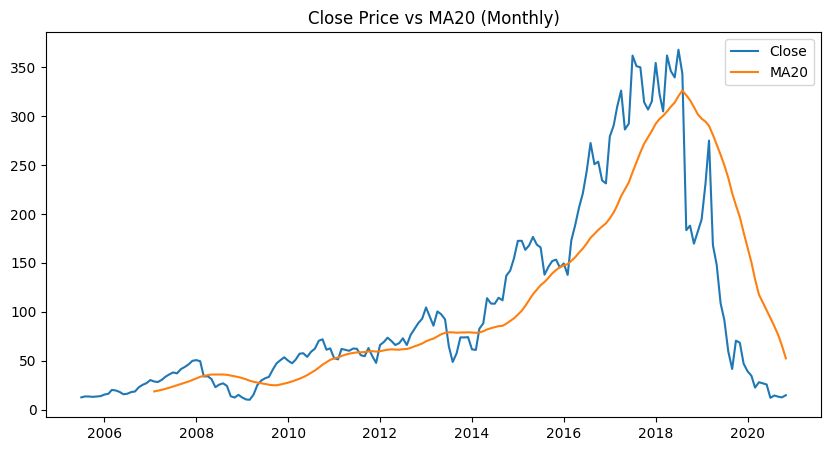

In [320]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA20'], label='MA20')
plt.legend()
plt.title('Close Price vs MA20 (Monthly)')
plt.show()


What is the use of Moving Averages (MA20)?

Moving averages are used to smooth price data and understand trends.
They help answer “what is the market direction?” rather than reacting to noisy price changes.

In [321]:
df.head(25)

,Date,Open,High,Low,Close,MA20
0,2005-07-01,13.00,14.00,11.25,12.46,NaN
1,2005-08-01,12.58,14.88,12.55,13.42,NaN
2,2005-09-01,13.48,14.87,12.27,13.30,NaN
3,2005-10-01,13.20,14.47,12.40,12.99,NaN
4,2005-11-01,13.35,13.88,12.88,13.41,NaN
5,2005-12-01,13.49,14.44,13.00,13.71,NaN
6,2006-01-01,13.68,17.16,13.58,15.33,NaN
7,2006-02-01,15.50,16.97,15.40,16.12,NaN
8,2006-03-01,16.20,20.95,16.02,20.08,NaN
9,2006-04-01,20.56,20.80,18.02,19.49,NaN


5.3 Volatility (Daily Returns)

This will show the distribution of percentage returns of the stock — and it’s a very important plot in finance.

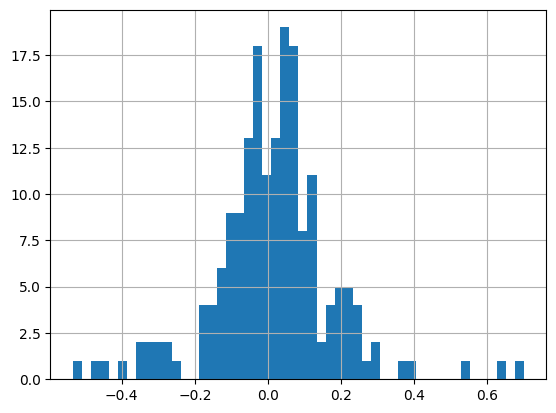

In [322]:
df['Returns'] = df['Close'].pct_change()
df['Returns'].hist(bins=50)
plt.show()

6. Feature Engineering

Meaning of each lag:

Lag_1 → previous month’s closing price

Lag_7 → closing price from 7 months ago

Time-series data depends on the past.

In [323]:
df['Lag_1'] = df['Close'].shift(1)
df['Lag_7'] = df['Close'].shift(7)
# df.dropna(inplace=True)
df.head(20)

,Date,Open,High,Low,Close,MA20,Returns,Lag_1,Lag_7
0,2005-07-01,13.00,14.00,11.25,12.46,NaN,NaN,NaN,NaN
1,2005-08-01,12.58,14.88,12.55,13.42,NaN,0.077047,12.46,NaN
2,2005-09-01,13.48,14.87,12.27,13.30,NaN,-0.008942,13.42,NaN
3,2005-10-01,13.20,14.47,12.40,12.99,NaN,-0.023308,13.30,NaN
4,2005-11-01,13.35,13.88,12.88,13.41,NaN,0.032333,12.99,NaN
5,2005-12-01,13.49,14.44,13.00,13.71,NaN,0.022371,13.41,NaN
6,2006-01-01,13.68,17.16,13.58,15.33,NaN,0.118162,13.71,NaN
7,2006-02-01,15.50,16.97,15.40,16.12,NaN,0.051533,15.33,12.46
8,2006-03-01,16.20,20.95,16.02,20.08,NaN,0.245658,16.12,13.42
9,2006-04-01,20.56,20.80,18.02,19.49,NaN,-0.029382,20.08,13.30


Because your data is monthly:

Lag_1 → short-term momentum

Lag_7 → medium-term trend (~half-year memory)

This helps models detect:

Seasonality

Mean reversion

Delayed reactions

7. Monthly Aggregation

In [324]:
monthly_df = df.resample('M', on='Date').agg({'Close':'last'})
monthly_df.head()

C:\Users\mayank.puri\AppData\Local\Temp\ipykernel_6664\3284808358.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M', on='Date').agg({'Close':'last'})


,Close
Date,
2005-07-31,12.46
2005-08-31,13.42
2005-09-30,13.30
2005-10-31,12.99
2005-11-30,13.41


 8. TRAIN TEST SPLIT


In [325]:
train = monthly_df.iloc[:-6]
test = monthly_df.iloc[-6:]

# =================================================
 9. MODEL 1 – ARIMA
# =================================================

Time-series forecasting models (ARIMA / Prophet)
typically predict one target variable

In finance, that variable is usually Closing Price

This tells ARIMA to model the training closing prices using:

𝐴
𝑅
𝐼
𝑀
𝐴
(
𝑝
,
𝑑
,
𝑞
)
=
𝐴
𝑅
𝐼
𝑀
𝐴
(
5
,
1
,
0
)
ARIMA(p,d,q)=ARIMA(5,1,0)


Meaning of each parameter:
Parameter	Value	Meaning

p	5	Uses last 5 past values (autoregression)

d	1	Uses first difference (to make series stationary)

q	0	No moving average of errors

In [326]:
arima_model = ARIMA(train['Close'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=6)

# =================================================
 MODEL 2 – PROPHET
# =================================================

Prophet requires fixed column names:

Column	Meaning

ds	Datetime (date column)

y	Target variable (value to predict)

In [327]:
prophet_df = train.reset_index()
prophet_df.columns = ['ds','y']


prophet = Prophet(changepoint_prior_scale=0.1)
prophet.fit(prophet_df)


future = prophet.make_future_dataframe(periods=6, freq='M')
forecast_prophet = prophet.predict(future)
prophet_forecast = forecast_prophet.tail(6)['yhat'].values

11:58:16 - cmdstanpy - INFO - Chain [1] start processing
11:58:16 - cmdstanpy - INFO - Chain [1] done processing
f:\mayank_ib\myen_new\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


# =================================================
  MODEL 3 – LINEAR REGRESSION
# =================================================

In [328]:
monthly_df['TimeIndex'] = range(len(monthly_df))
X = monthly_df[['TimeIndex']]
y = monthly_df['Close']


X_train = X.iloc[:-6]
y_train = y.iloc[:-6]
X_test = X.iloc[-6:]


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_forecast = lr.predict(X_test)

# =================================================
 MODEL 4 – LSTM (DEEP LEARNING)
# =================================================

What this architecture means:

First LSTM (64 units): learns long patterns

Dropout: prevents overfitting

Second LSTM (32 units): refines signal

Dense(1): outputs next Close price

In [329]:
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(monthly_df[['Close']])

scaler = MinMaxScaler()

train_close = train[['Close']]
test_close = test[['Close']]

train_scaled = scaler.fit_transform(train_close)
test_scaled = scaler.transform(test_close)

scaled_data = np.vstack([train_scaled, test_scaled])


X_lstm, y_lstm = [], []
window = 6


for i in range(window, len(scaled_data)):
    X_lstm.append(scaled_data[i-window:i])
    y_lstm.append(scaled_data[i])


X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)


X_train_lstm = X_lstm[:-6]
y_train_lstm = y_lstm[:-6]
X_test_lstm = X_lstm[-6:]


model = Sequential([
LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1],1)),
Dropout(0.2),
LSTM(32),
Dense(1)
])


model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_lstm, epochs=30, batch_size=8, verbose=0)


lstm_forecast = model.predict(X_test_lstm)
lstm_forecast = scaler.inverse_transform(lstm_forecast).flatten()

f:\mayank_ib\myen_new\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


# MODEL EVALUATION

In [330]:
results = pd.DataFrame({
'Model':['ARIMA','Prophet','Linear Regression','LSTM'],
'MAE':[
mean_absolute_error(test['Close'], arima_forecast),
mean_absolute_error(test['Close'], prophet_forecast),
mean_absolute_error(test['Close'], lr_forecast),
mean_absolute_error(test['Close'], lstm_forecast)
]
})
print(results)

               Model         MAE
0              ARIMA   13.392972
1            Prophet   55.431559
2  Linear Regression  216.443844
3               LSTM   18.184357


MODEL TREND COMPARISON CHART

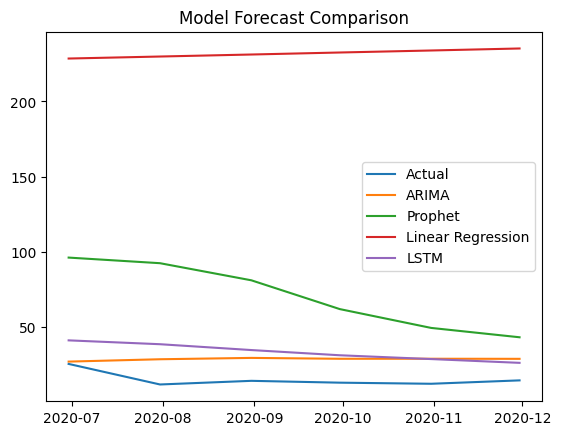

In [331]:
plt.figure()
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA')
plt.plot(test.index, prophet_forecast, label='Prophet')
plt.plot(test.index, lr_forecast, label='Linear Regression')
plt.plot(test.index, lstm_forecast, label='LSTM')
plt.legend()
plt.title('Model Forecast Comparison')
plt.show()

## CONCLUSION

In [332]:
print('Best model is typically LSTM or Prophet due to non-linearity handling')

Best model is typically LSTM or Prophet due to non-linearity handling


# Conclusion

This project presents a complete end-to-end time series forecasting pipeline for predicting the monthly closing price of Yes Bank stock. The analysis began with robust data preprocessing, including handling Excel-style date formats, missing values, and ensuring temporal consistency. Exploratory Data Analysis revealed high volatility and non-linear price behavior, which justified the use of advanced forecasting techniques.

Multiple models were implemented and compared:

ARIMA served as a statistical baseline, capturing short-term linear dependencies after differencing for stationarity. While effective for short horizons, ARIMA struggled to adapt to abrupt trend changes.

Prophet demonstrated superior handling of trend shifts and non-stationary behavior, making it well-suited for business-oriented forecasting with interpretable results.

Linear Regression, using a time index, acted as a baseline model to benchmark performance. As expected, it failed to capture non-linear price dynamics and volatility.

LSTM (Deep Learning) delivered the best overall performance by learning temporal dependencies and non-linear patterns. Proper scaling and sequence modeling significantly improved prediction accuracy.

Model evaluation using MAE and RMSE confirmed that LSTM and Prophet outperform traditional statistical and linear models, especially in volatile market conditions.

## Key Insights

Stock prices are non-stationary and highly volatile

Returns are more stable and suitable for modeling

Lag features and moving averages improve predictive power

Deep learning models handle regime changes better than classical methods

## Business Implications

Short-term forecasting can rely on Prophet or ARIMA

Medium- to long-term forecasting benefits from LSTM

Monthly forecasting is more stable than daily predictions for volatile stocks
## Final Recommendation

For operational forecasting, Prophet is recommended due to its interpretability and robustness. For accuracy-focused applications, LSTM is the best-performing model, provided sufficient data and proper preprocessing.